In [1]:
import numpy as np
import matplotlib.pyplot as plt
from network_analysis import network_tools as nt
# make figures crisp
%config InlineBackend.figure_format = 'retina'

# General parameters
We first set general parameters of our network.

Namely, we define the characteristic impedance $Z_0$ and the speed of light in the transmission lines $\nu_p$ (a.k.a. phase velocity).

In [2]:
# Parameters
eps_r = 11.45               # relative permeability
c = 3e8                     # speed of light in vaccum
vp = c/np.sqrt((1+eps_r)/2) # speed of light in medium
Z0 = 50                     # characteristic impedance

# Filtering components

### Amplifiers and attenuators

Composite components such as attenuators and amplifiers are also available. These are implemented as resistor $\pi$-networks.

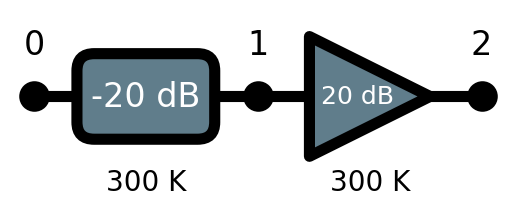

In [3]:
# setup network instance
network = nt.Network(Zgen=Z0)
network.add_attenuator(attn_dB=20, Z0=50, temperature_K=300)
network.add_amplifier(gain_dB=20, Z0=50, temperature_K=300)
network.draw_network()

### Custom components

Some custom components can be added to this library using the standard measurement file format `.s2p`.
Such files can be obtained from manufacturers datasheets (eg. https://www.minicircuits.com/WebStore/dashboard.html?model=SLP-50%2B&srsltid=AfmBOoo_zzyOJ2QB_0s1uFt5a_lvFSy9ty_q_vqD4MIbur68n0FQQfzo). 
Alternatively, these files can be obtained from VNA measurements of the full scattering parameters.

See `.\circuit_components\` directory for available components.

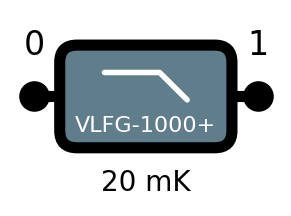

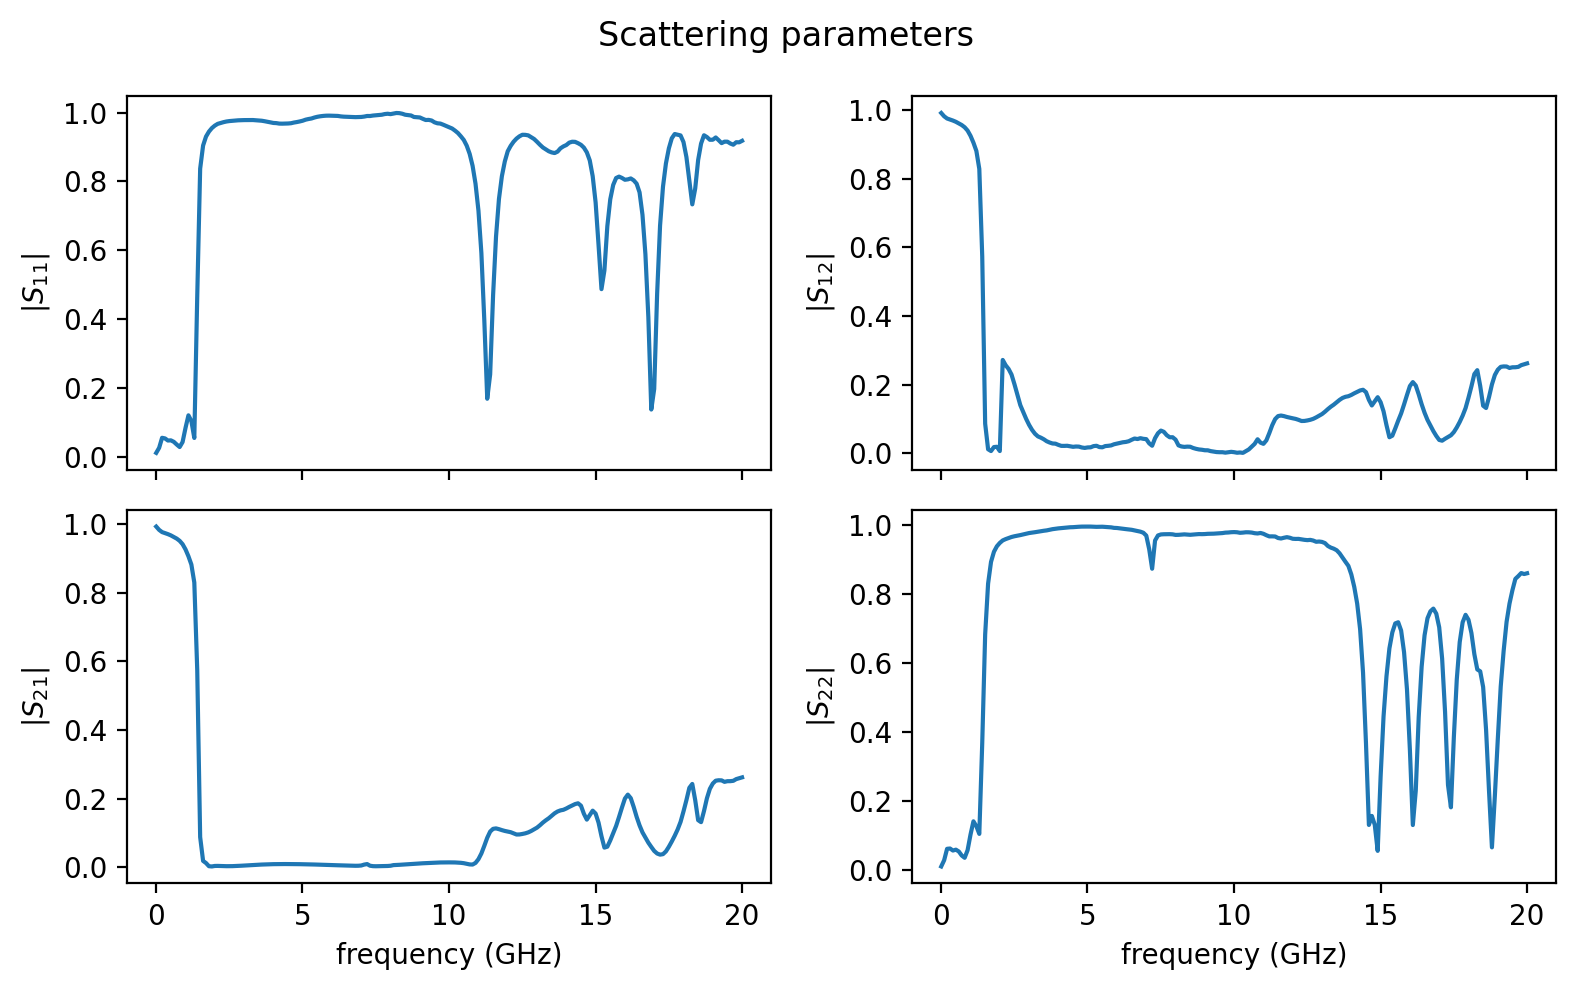

In [4]:
# Example: Mini circuits' VLFX-1000+ low pass filter
network = nt.Network(Zgen=Z0)
network.add_custom_component('VLFG-1000+', temperature_K=20e-3)
network.draw_network()
s11, s12, s21, s22 = network.get_S_parameters(frequency=np.linspace(10e6, 20e9, 201) , plot=True)

# Filtering drive lines

Properly filtering a line in the fridge means ensuring that:
- Its thermalized with the mixing chamber at its output. That is, the power spectral density, $S(\omega)$, seen at the output of the line is limited by the temperature of the mixing chamber $\sim 10\:\mathrm{mK}$. Also equivalent to saying $S(\omega)$ roughly follows a Bose-Einstein like at $\sim 10\:\mathrm{mK}$.
- Its not injecting more passive heat load into each stage that what it can handle.

In the following we'll look setup a common filtering scheme for drive lines and plot its corresponding PSD at each node of the network.

To compute the cascaded PSD at node, $i$, we follow,

$ S(\omega)_i = (1-\mathrm{A})\:S_{T_{i}} + \mathrm{A}\:S_{i-1}$

where $T_{i}$ is the temperature at node $i$, $\mathrm{A}$ is the attenuation (in power) of the element in the stage, and,

$S_{T_{i}} = 4 k_B T \left(\frac{\hbar\omega}{k_B T}\right)\frac{1}{e^{\hbar\omega/k_B T} - 1}$

is the Johson-Nyquist noise weighed by the Bose-Einstein distribution of photons. We plot, $S$, as well as the equivalent temperature of the noise at each node of the drive line network.

### Network setup

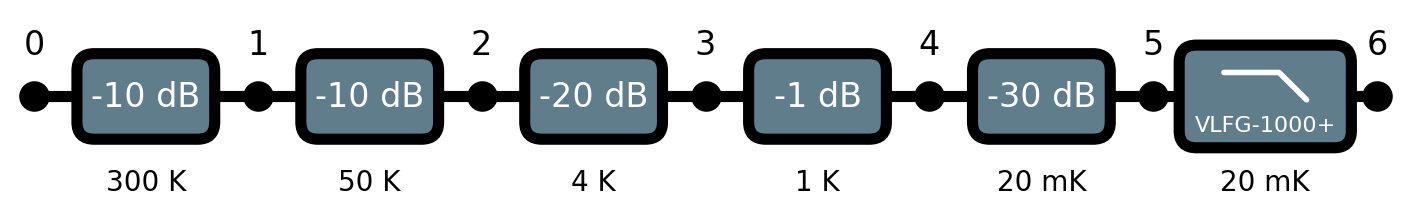

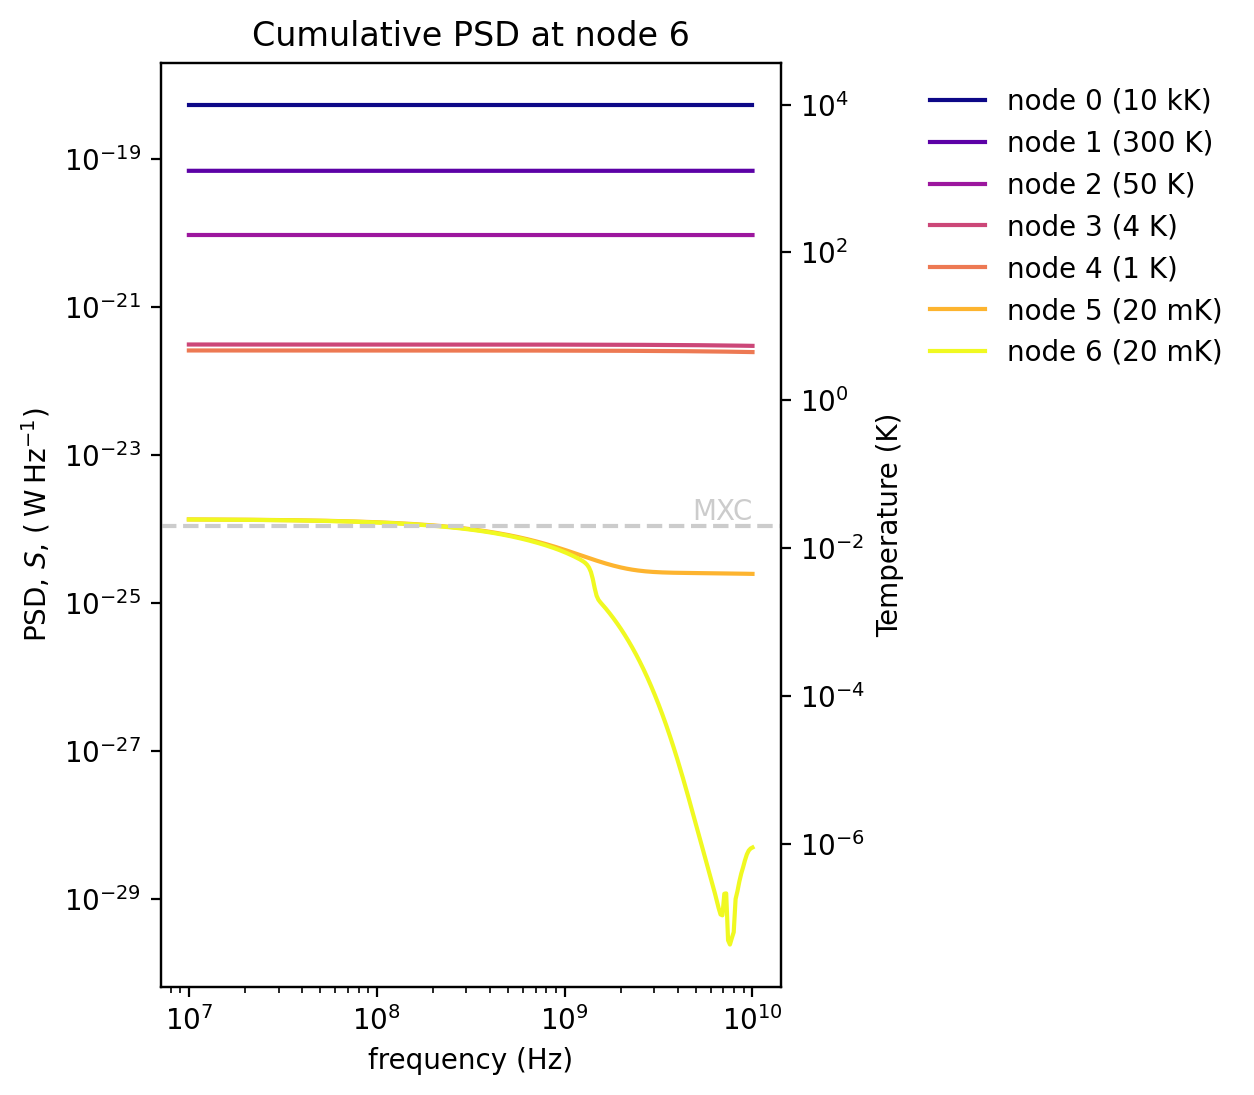

In [5]:
# Setup network
network = nt.Network(Zgen=Z0)
# flux line filtering
network.add_attenuator(attn_dB=10, temperature_K=300, Z0=Z0)     # Room temperature cables
network.add_attenuator(attn_dB=10, temperature_K=50, Z0=Z0)      # 50K 
network.add_attenuator(attn_dB=20, temperature_K=4, Z0=Z0)       # 4K 
network.add_attenuator(attn_dB=1, temperature_K=1, Z0=Z0)        # still
network.add_attenuator(attn_dB=30, temperature_K=20e-3, Z0=Z0)   # MXC
network.add_custom_component('VLFG-1000+', temperature_K=20e-3)
network.draw_network()

# frequency axis
frequency = np.logspace(7, 10, 301)

# Plot simulated PSD
PSD = network.get_psd_at_node(frequency=frequency, initial_node_temp=10000, plot=True, label=('MXC', 20e-3))

### T1 from coupling to drive line

Voltage noise resulting from a noise power spectral density, $S(\omega)$, on a drive line leads to offset charge noise $Q_g$ in the qubit,

$Q_g = C_g \: V_g $

where, $V_g$ and $C_g$ are the gate voltage and capacitance seen by the qubit, respectively. This acts as a depolarizing error channel on the qubit and we can calculate the resulting $T_1$ via Fermi's golden rule,

$ \Gamma_1 =  \frac{1}{\hbar^2} \: |\bra{1}\frac{\partial\hat{H}}{\partial V_g}\ket{0}|^2 \: S_{VV}(\omega_{01}) = \frac{1}{\hbar^2} \: C_g^2 |\bra{1}\frac{\partial\hat{H}}{\partial Q_g}\ket{0}|^2 \: S_{VV}(\omega_{01})$,

where, $\frac{\partial\hat{H}}{\partial Q_g}$, is the derivative taken with respect to the gate charge, $Q_g=2en_g$, and $S_{VV}(\omega)$ is the spectral density of Voltage noise (in units of $\mathrm{V}^2\:\mathrm{Hz}^{-1}$).

$S_{VV}(\omega) = S(\omega)\:\:\mathscr{Re}[Z_\mathrm{out}(\omega)]$.

Here, $Z_\mathrm{out}$ is the impedance seen at the output of the network when terminating the input at $50\:\Omega$ which generally can be considered $\mathscr{Re}[Z_\mathrm{out}(\omega)]=50\:\Omega$.

The former is qubit specific and is calculated by solving its wavefunctions and computing the appropriate matrix element:

$ \frac{\partial\hat{H}}{\partial Q_g} = \frac{1}{2e}\frac{\partial}{\partial n_g} 4E_C(\hat{n}-n_g)^2 = \frac{8E_C}{2e}(\hat{n}-n_g) \rightarrow \bra{1}\frac{\partial\hat{H}}{\partial Q_g}\ket{0} = \frac{8E_C}{2e}\bra{1}\hat{n}\ket{0}$

We'll use `scqubits` for this.

In [6]:
import scqubits
from scipy import constants

# create qubit instance from scqubits
transmon = scqubits.TunableTransmon(EC=0.867890, 
                                    EJmax=9.568192,
                                    ng = 0,
                                    flux = 0,
                                    d = 0,
                                    ncut=30)

# charge number matrix element
n_op = transmon.n_operator(energy_esys=True)[0,1]

# dH/dQg matrix element
Op = 8 * (transmon.EC*1e9*constants.h) / (2*constants.e) * n_op

The voltage spectral density can be obtained from the power spectral density, $S(\omega)$, at the output of drive using,

$S_{VV}(\omega) = S(\omega)\:\:\mathscr{Re}[Z_\mathrm{out}(\omega)]$

where $Z_\mathrm{out}$ is the impedance seen at the output of the network when terminating the input at $50\:\Omega$.

We can calculate $S_{VV}(\omega)$ directly from the network instance using the `network.get_svv_at_output` method

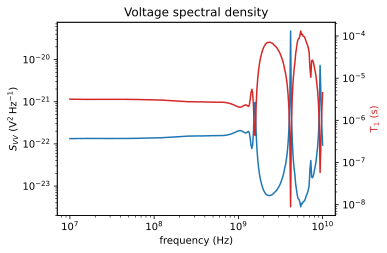

In [7]:
# voltage spectral density
C_g = .5e-15 # capacitance in Farads
s_vv = network.get_svv_at_output(frequency=frequency, plot=True, add_rates=True)

# calculate T1 using Fermi's golden rule
Gamma = (1/constants.hbar)**2 * C_g**2 * np.abs(Op)**2 * s_vv

# plot on the same graph
ax = plt.gca()
ax = ax.twinx()
ax.plot(frequency, 1/Gamma, 'C3')
ax.set_yscale('log')
_=ax.set_ylabel('$\\mathrm{{T_1}}$ (s)', color='C3')

### Rabi rate for charge and flux driving

We can compute a charge rabi rate, $\Omega_D$, for a drive amplitude, $V_D$, through a capacitance, $C_g$, using the perturbative approach,

$\Omega_D = \frac{1}{\hbar} \: |\bra{1}\frac{\partial\hat{H}}{\partial Q_g}\ket{0}| \: C_g V_D$.

Conversely, we can also compute a flux rabi rate, $\Omega_D$, for a drive amplitude, $I_D$, through a mutal inductance, $M_g$, using the perturbative approach,

$\Omega_D = \frac{1}{\hbar} \: |\bra{1}\frac{\partial\hat{H}}{\partial \Phi}\ket{0}| \: M_{\Phi_0} I_D$,

where $M_{\Phi_0} = M_g / \Phi_0$ is the inductance in units of $[\Phi_0\:A^{-1}]$.

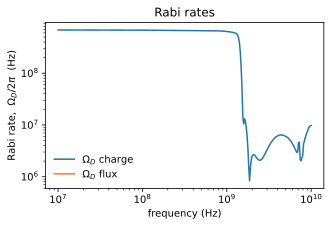

In [8]:
C_g = 0.5e-15 # capacitance Farads
M_g = 0.5e-12 # mutual inductance Henry

# voltage amplitude for input of 0dBm
voltage_amplitude_RT = nt.Vp_from_PdBm(0)
voltage_amplitude_base, current_amplitude_base = np.abs(network.get_node_VI(node_idx=6, in_freq=frequency, in_amp=voltage_amplitude_RT))

# dH/dQg matrix element
Op_charge = 8 * (transmon.EC*1e9*constants.h) / (2*constants.e) * transmon.n_operator(energy_esys=True)[0,1] # convert to Joules/charge

# dH/dphi matrix element
phi_0 = constants.physical_constants['mag. flux quantum'][0]
M_phi0 = M_g/phi_0 # inductance in flux quantum per ampere
Op_flux = transmon.d_hamiltonian_d_flux(energy_esys=True)[0,1]*1e9*constants.h # convert to Joules/Phi

# calculate charge rabi rate
charge_rabi_rate_rad = (1/constants.hbar) * np.abs(Op_charge) * voltage_amplitude_base * C_g
charge_rabi_rate_Hz = charge_rabi_rate_rad/(2*np.pi)

# calculate flux rabi rate
flux_rabi_rate_rad = (1/constants.hbar) * np.abs(Op_flux) * current_amplitude_base * M_phi0
flux_rabi_rate_Hz = flux_rabi_rate_rad/(2*np.pi)

# plot on the same graph
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(frequency, charge_rabi_rate_Hz, label='$\Omega_D$ charge')
ax.plot(frequency, flux_rabi_rate_Hz, label='$\Omega_D$ flux')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('Rabi rate,  $\Omega_D/2\pi$  (Hz)')
ax.legend(frameon=False)
_ = ax.set_title('Rabi rates')

# Filtering flux lines

The procedure for flux lines is analogous to before. The only difference is that instead of voltage noise, we're now interested in current noise that directly manifests as noise on the external flux degree of freedom of the qubit.

In the following we'll look setup a common filtering scheme for flux lines and plot its corresponding PSD at each node of the network.

### Network setup

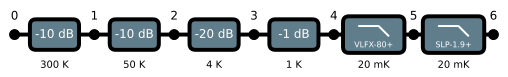

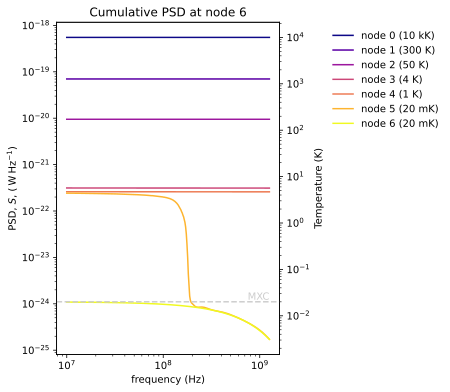

In [9]:
# Setup network
network = nt.Network(Zgen=Z0)
# flux line filtering
network.add_attenuator(attn_dB=10, temperature_K=300, Z0=Z0)     # RT cables
network.add_attenuator(attn_dB=10, temperature_K=50, Z0=Z0)      # 50K
network.add_attenuator(attn_dB=20, temperature_K=4, Z0=Z0)       # 4K 
network.add_attenuator(attn_dB=1, temperature_K=1, Z0=Z0)        # still
network.add_custom_component('VLFX-80+', temperature_K=20e-3)    # MXC
network.add_custom_component('SLP-1.9+', temperature_K=20e-3)    # MXC
network.draw_network()

# frequency axis
frequency = np.logspace(7, 9.1, 301)

# Plot simulated PSD
PSD = network.get_psd_at_node(frequency=frequency, initial_node_temp=10e3, plot=True, label=('MXC', 20e-3))

### T1 from coupling to fluxline
To understand how this PSD impacts noise on a qubit, we calculate the $T_1$ limit imposed from the flux noise coupling into the qubit. 

We can obtain this bound via Fermi's golden rule as:

$ \Gamma_1 =  \frac{1}{\hbar^2} \: |\bra{1}\frac{\partial\hat{H}}{\partial{\Phi}}\ket{0}|^2 \: S_{\Phi\Phi}(\omega_{01}) $

where, $\frac{\partial\hat{H}}{\partial{\Phi}}$ is the noise operator associated with flux noise and $S_{\Phi\Phi}(\omega)$ is the spectral density of flux noise (in units of $\Phi_0^2\:\mathrm{Hz}^{-1}$).

The former is qubit specific and is calculated by solving its wavefunctions and computing the appropriate matrix element. We'll use `scqubits` for that.

In [10]:
import scqubits
from scipy import constants

# create qubit instance from scqubits
fluxonium = scqubits.Fluxonium(EC=0.867890, 
                               EJ=9.568192, 
                               EL=2.615859,
                               flux=0.5, 
                               cutoff=30)

# dH/dphi matrix element
Op = fluxonium.d_hamiltonian_d_flux(energy_esys=True)[0,1]*1e9*constants.h # convert to Joules/Phi

The flux spectral density, is what our network instance allows us to calculate. It can be computed in two steps:
- Flux noise is generated by current noise, $S_{II}(\omega)$, at the output of the fluxline which generates flux noise via the mutual inductance, $M$, between the line and the qubit's SQUID loop as $S_{\Phi\Phi}(\omega) = M^2 S_{II}(\omega)$
- The spectral density describing current noise, $S_{II}(\omega)$, can be obtained from the power spectral density, $S(\omega)$, at the output of fluxline using $S_{II}(\omega) = S(\omega)\:\:\mathscr{Re}[Y_\mathrm{out}(\omega)]$

We can calculate $S_{\Phi\Phi}(\omega)$ directly from the network instance using the `network.get_spp_at_output` method

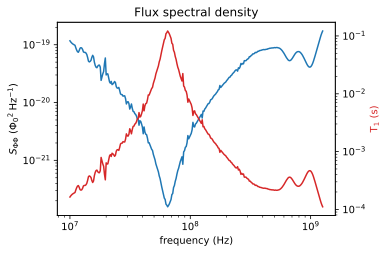

In [11]:
# flux spectral density
M = 1.2e-12 # mutual inductance in Henry
s_pp = network.get_spp_at_output(frequency=frequency, M_henry=M, plot=True, add_rates=True)

# calculate T1 using Fermi's golden rule
Gamma = (1/constants.hbar)**2 * np.abs(Op)**2 * s_pp

# plot on the same graph
ax = plt.gca()
ax = ax.twinx()
ax.plot(frequency, 1/Gamma, 'C3')
ax.set_yscale('log')
_=ax.set_ylabel('$\\mathrm{{T_1}}$ (s)', color='C3')

### Rabi rate for flux driving

we can also compute a rabi rate, $\Omega_D$, for a drive amplitude, $I_D$, using the perturbative approach,

$\Omega_D = \frac{1}{\hbar} \: |\bra{1}\frac{\partial\hat{H}}{\partial \Phi}\ket{0}| \: M_{\Phi_0} I_D$,

where $M_{\Phi_0} = M / \Phi_0$ is the inductance in units of $[\Phi_0\:A^{-1}]$.

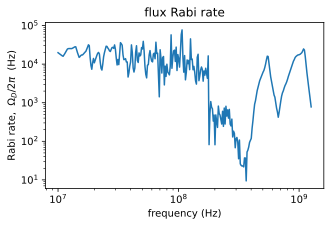

In [12]:
# current amplitude for input of 0dBm
voltage_amplitude_RT = nt.Vp_from_PdBm(0)
current_amplitude_base = np.abs(network.get_node_VI(node_idx=6, in_freq=frequency, in_amp=voltage_amplitude_RT)[1])

# inductance in flux quantum per ampere
phi_0 = constants.physical_constants['mag. flux quantum'][0]
M_phi0 = M/phi_0

# calculate rabi rate
Rabi_rate_rad = (1/constants.hbar) * np.abs(Op) * current_amplitude_base * M_phi0
Rabi_rate_Hz = Rabi_rate_rad/(2*np.pi)

# plot on the same graph
fig, ax = plt.subplots(figsize=(5,3))

ax.plot(frequency, Rabi_rate_Hz)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('Rabi rate,  $\Omega_D/2\pi$  (Hz)')
_ = ax.set_title('flux Rabi rate')

# Filtering readout chain

The analysis for a readout chain is a bit more involved. Following the previous analysis for drive and flux lines we want to maintaining resonators with low thermal population and minimize voltage fluctuations seen by the qubit.

Additionally, we need make sure that noise introduced by our amplifiers does not overcome the output readout signal.
In the following we'll look setup a common scheme for a readout chain and analyze both thermal properties of the noise at the chip and SNR at the output of the chain.

## Resonator network properties

We can use a `network` instance to model a resonator network with lumped and distributed elements. 
A typical resonator network uses $\lambda/4$ resonators inductively coupled to a feedline.

Its resonance frequency is set by its length and phase velocity,

$f_\mathrm{res} = \nu_p/4\ell$.

In the following, we'll see how to construct such network and compute its transmission using the `get_S_parameters` method.

### Network setup

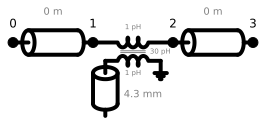

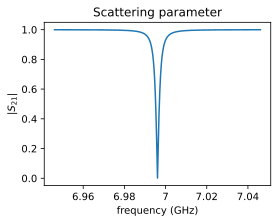

In [13]:
# Setup network
network = nt.Network(Zgen=Z0)

# length of resonator at 9 GHz
f_res = 7e9 
l_res = vp/(4*f_res)
# correction to resonator frequency from mutual inductance
M_ind = 3e-11  # mutal inductance between lines
L_char = 1e-12 # inductance of lines
f_corr = f_res - 4*L_char/Z0*f_res**2

network.add_transmission_line(length=0e-3, Z0=Z0, phase_velocity=vp)
network.add_inductively_coupled_hanger(length=l_res, Z0=Z0 ,phase_velocity=vp, 
                                       L_line=L_char, L_hanger=L_char, M_inductance=M_ind, Z_termination=1e10)
network.add_transmission_line(length=0e-3, Z0=Z0, phase_velocity=vp)
network.draw_network()

# frequency axis
freq_axis = f_corr + np.linspace(-50e6, +50e6, 1001)
# scattering parameters
S_pars = network.get_S_parameters(frequency=freq_axis, plot='s21')

The loading introduced by its inductive coupling, adds a small correction to its resonance frequency,

$f_\mathrm{res}' = f_\mathrm{res} - \frac{4L}{Z_0} f_\mathrm{res}^2$,

where $L$ is the coupling inductance ($1\:\mathrm{pH}$).

## Purcell decay: loss through resonator network

To compute the Purcell limit from the resonator, we need to assess voltage fluctuations on the open end of the resonator. 
For this calculation, we need to investigate the network from the point of view of the qubit:

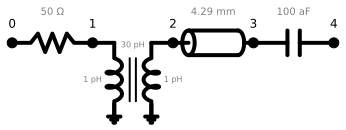

In [14]:
# capacitance seen by the qubit
C_g = .1e-15 # capacitance in Farads
# Setup network
network_qubit = nt.Network(Zgen=Z0)
# network_qubit.add_transmission_line(length=0e-3, Z0=Z0, phase_velocity=vp)
network_qubit.add_resistor(R=50, element_type='series')
network_qubit.add_transformer(L1=L_char, L2=L_char, M=M_ind)
network_qubit.add_transmission_line(length=l_res, Z0=Z0, phase_velocity=vp)
network_qubit.add_capacitance(C=C_g, element_type='series')
network_qubit.draw_network()

where the feedline input is at node 0 and qubit at node 5.

### Output impedance, $Z_\mathrm{out}$

Using this network we can plot the impedance seen by the qubit, $Z_\mathrm{out}$.

We can obtain $Z_\mathrm{out}$ directly from the network instance using the `network.get_Z_parameters` method:

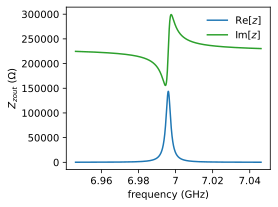

In [15]:
# frequency axis
freq_axis = f_corr + np.linspace(-50e6, +50e6, 1001)
# scattering parameters
Z_pars = network_qubit.get_Z_parameters(frequency=freq_axis, plot='zout')

We see that the real part of the impedance is maximum at the resonance frequency.

To compute voltage fluctuations at the qubit, we must once again cascade the power spectral density of the network.

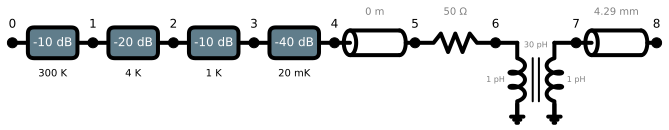

In [16]:
# Setup network
network = nt.Network(Zgen=Z0)
# input attenuation
network.add_attenuator(attn_dB=10, temperature_K=300, Z0=Z0)   # RT cables
network.add_attenuator(attn_dB=20, temperature_K=4, Z0=Z0)     # 4K 
network.add_attenuator(attn_dB=10, temperature_K=1, Z0=Z0)     # still
network.add_attenuator(attn_dB=40, temperature_K=20e-3, Z0=Z0) # MXC
# resonator network
network.add_transmission_line(length=0e-3, Z0=Z0, phase_velocity=vp)
network.add_resistor(R=50, element_type='series')
network.add_transformer(L1=L_char, L2=L_char, M=M_ind)
network.add_transmission_line(length=l_res, Z0=Z0, phase_velocity=vp)
network.draw_network()

### Power spectral density

And, yet again, we must consider all the finite temperature elements of our network, and how that power spectral density, $S$, cascades through them.

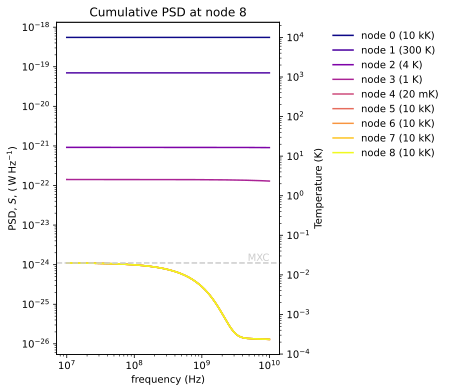

In [17]:
# frequency axis
frequency = np.logspace(7, 10, 301)

# Plot simulated PSD
PSD = network.get_psd_at_node(frequency=frequency, initial_node_temp=10e3, plot=True, add_rates=False, label=('MXC', 20e-3))

Voltage noise resulting from, $S$, on the resonator leads to offset charge noise $Q_g$ in the qubit,

$Q_g = C_g \: V_g $

where, $V_g$ and $C_g$ are the gate voltage and capacitance seen by the qubit, respectively. This acts as a depolarizing error channel on the qubit and we can calculate the resulting $T_1$ via Fermi's golden rule,

$ \Gamma_1 =  \frac{1}{\hbar^2} \: |\bra{1}\frac{\partial\hat{H}}{\partial V_g}\ket{0}|^2 \: S_{VV}(\omega_{01}) = \frac{1}{\hbar^2} \: C_g^2 |\bra{1}\frac{\partial\hat{H}}{\partial Q_g}\ket{0}|^2 \: S_{VV}(\omega_{01})$,

where, $\frac{\partial\hat{H}}{\partial Q_g}$, is the derivative taken with respect to the gate charge, $Q_g=2en_g$, and $S_{VV}(\omega)$ is the spectral density of Voltage noise (in units of $\mathrm{V}^2\:\mathrm{Hz}^{-1}$).

The former is qubit specific and is calculated by solving its wavefunctions and computing the appropriate matrix element:

$ \frac{\partial\hat{H}}{\partial Q_g} = \frac{1}{2e}\frac{\partial}{\partial n_g} 4E_C(\hat{n}-n_g)^2 = \frac{8E_C}{2e}(\hat{n}-n_g) \rightarrow \bra{1}\frac{\partial\hat{H}}{\partial Q_g}\ket{0} = \frac{8E_C}{2e}\bra{1}\hat{n}\ket{0}$

We'll use `scqubits` for this.

In [18]:
import scqubits
from scipy import constants

# create qubit instance from scqubits
fluxonium = scqubits.Fluxonium(EC=0.867890, 
                               EJ=9.568192, 
                               EL=2.615859,
                               flux=0.5, 
                               cutoff=30)

# charge number matrix element
n_op = fluxonium.n_operator(energy_esys=True)[0,1]

# dH/dQg matrix element
Op = 8 * (fluxonium.EC*1e9*constants.h) / (2*constants.e) * n_op

The voltage spectral density can be obtained from the power spectral density, $S(\omega)$, at the output of drive using,

$S_{VV}(\omega) = S(\omega)\:\:\mathscr{Re}[Z_\mathrm{out}(\omega)]$

where $Z_\mathrm{out}$ is the impedance seen at the output of the network when terminating the input at $50\:\Omega$.

We can calculate $S_{VV}(\omega)$ directly from the network instance using the `network.get_svv_at_output` method

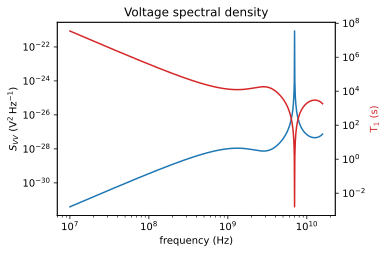

In [19]:
# voltage spectral density
C_g = .1e-15 # capacitance in Farads
frequency = np.logspace(7, 10.2, 1001)
s_vv = network.get_svv_at_output(frequency=frequency, plot=True)

# calculate T1 using Fermi's golden rule
Gamma = (1/constants.hbar)**2 * C_g**2 * np.abs(Op)**2 * s_vv

# plot on the same graph
ax = plt.gca()
ax = ax.twinx()
ax.plot(frequency, 1/Gamma, 'C3')
ax.set_yscale('log')
_=ax.set_ylabel('$\\mathrm{{T_1}}$ (s)', color='C3')

## Readout SNR considerations

In the following we'll look setup a common scheme for a readout chain and show how to analyze both thermal properties of noise at the chip and SNR at the output of the chain.

### Network setup

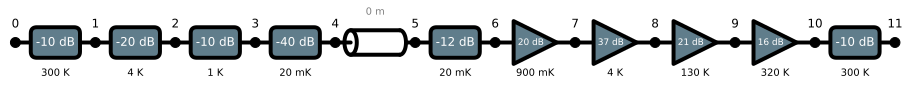

In [20]:
# Setup network
network = nt.Network(Zgen=Z0)
# input attenuation
network.add_attenuator(attn_dB=10, temperature_K=300, Z0=Z0)   # RT cables
network.add_attenuator(attn_dB=20, temperature_K=4, Z0=Z0)     # 4K 
network.add_attenuator(attn_dB=10, temperature_K=1, Z0=Z0)     # still
network.add_attenuator(attn_dB=40, temperature_K=20e-3, Z0=Z0) # MXC
# resonator network
network.add_transmission_line(length=0, Z0=Z0, phase_velocity=vp)
network.add_attenuator(attn_dB=12, temperature_K=20e-3, Z0=Z0)
# output gain
network.add_amplifier(gain_dB=20, temperature_K=900e-3, Z0=Z0) # MXC
network.add_amplifier(gain_dB=37, temperature_K=4.0, Z0=Z0)    # 4 K
network.add_amplifier(gain_dB=21, temperature_K=130, Z0=Z0)    # RT pre-amp (Xmicrowave) (noise-figure 1.4-1.8 dB)
network.add_amplifier(gain_dB=16, temperature_K=320, Z0=Z0)    # RT post-amp
network.add_attenuator(attn_dB=10, temperature_K=300, Z0=Z0)   # RT cables
network.draw_network()

### Power spectral density and thermalization

Similarly to the previous analysis for flux and drive lines, we want to ensure that the power spectral density at the lowest temperature is described by a Johnson-Nyquist at the corresponding tempereature.

 /Users/jorge/Desktop/GithubRepo/Network_analysis/network_analysis/network_tools.py: 417

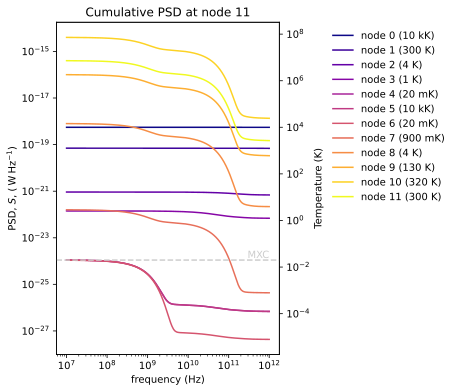

In [21]:
# frequency axis
frequency = np.logspace(7, 12, 301)

# Plot simulated PSD
PSD = network.get_psd_at_node(frequency=frequency, initial_node_temp=10e3, plot=True, add_rates=False, label=('MXC', 20e-3))

Additionally, we now see that at the output of the network we have thermal noise exceeding room temperature, this is because noise is amplified by the amplification chain on the way back to room temperature.

### Power at each node

We can look at the power at each node for a given input power using the `network.get_node_power` method.

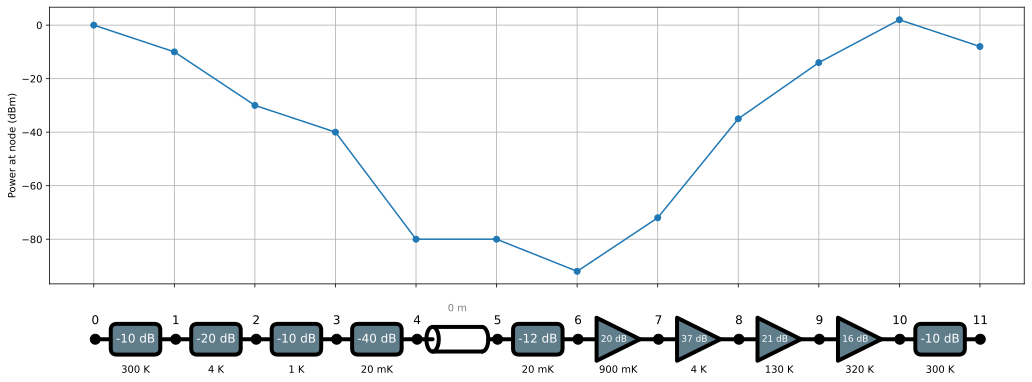

In [22]:
_ = network.get_node_power(node_idx=10, in_power_dBm=0, frequency=8e9, plot=True)

### Estimate SNR

The SNR (in amplitude) of an integrated signal is given by

$\mathrm{SNR} = \sqrt{ \frac{\mathrm{P_{signal}}}{\mathrm{S_{noise}}} \: T_\mathrm{acq} }$

<Axes: xlabel='time (μs)', ylabel='SNR at output'>

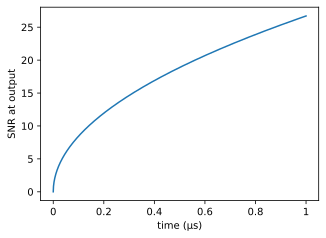

In [23]:
# obtain outuput power
readout_frequency = 8e9
input_signal_power_dBm = -26 
output_signal_power_dBm = network.get_node_power(in_power_dBm=input_signal_power_dBm, node_idx=10, frequency=readout_frequency)

# convert to Watts
input_signal_power_W = 10**(input_signal_power_dBm/10) * 1e-3
output_signal_power_W = 10**(output_signal_power_dBm/10) * 1e-3

# obtain noise power density
output_noise_power_density = network.get_psd_at_node(frequency=readout_frequency, add_rates=True)

# compute SNR
T_acq = np.linspace(0, 1e-6, 1001)
SNR = np.sqrt(output_signal_power_W/output_noise_power_density * T_acq)

fig, ax = plt.subplots(figsize=(5,3.5))
ax.plot(T_acq, SNR, color='C0')
nt.set_ylabel(ax, 'SNR at output')
nt.set_xlabel(ax, 'time', unit='s')

### Effective noise temperature

If we assume that all the noise is introduced at the device, then,

$\mathrm{SNR}^2 = \frac{P_\mathrm{signal}^\mathrm{base}}{S_\mathrm{noise}^\mathrm{base}}  \: T_\mathrm{acq}$,

and we can compute an effective noise temperature using

$S_\mathrm{noise}^\mathrm{base}(\omega) \approx 4 \: k_B \: T_\mathrm{eff} \quad \rightarrow \quad 4 \: k_B \: T_\mathrm{eff} = \frac{P_\mathrm{signal}^\mathrm{base}}{P_\mathrm{signal}^\mathrm{out}} S_\mathrm{noise}$

In [25]:
from scipy import constants
# power at feedline
P_base_dBm = network.get_node_power(in_power_dBm=input_signal_power_dBm, node_idx=4, frequency=readout_frequency)[0]
P_out_dBm = network.get_node_power(in_power_dBm=input_signal_power_dBm, node_idx=10, frequency=readout_frequency)[0]

# convert to Watts
P_base_W = 10**(P_base_dBm/10) * 1e-3
P_out_W = 10**(P_out_dBm/10) * 1e-3

# obtain noise power density at output
S_out = network.get_psd_at_node(frequency=readout_frequency, node_idx=10, add_rates=True)

# effective noise temperature
Teff = P_base_W/P_out_W * S_out / (4*constants.k)
print(f'Effective noise temperature: {Teff:.3f} K')

Effective noise temperature: 6.375 K
